## Data Prep

In [3]:
pip install prophet

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 5.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 822.9/822.9 kB 15.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 7.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import logging
import warnings
from sklearn.metrics import mean_squared_error

logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('numexpr').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [102]:
# follow same data prep procedures from ARIMA
data = pd.read_excel("owid-covid-data.xlsx")
italy_data = data[data['location'] == "Italy"]
italy_data = italy_data[['date', 'new_cases']]
#rename for prophet
italy_data.rename(columns={'date': 'ds', 'new_cases': 'y'}, inplace=True)
#drop missing values
italy_data['ds'] = pd.to_datetime(italy_data['ds'])
dates_to_drop = ['2023-09-15', '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19', '2023-09-20']
italy_data = italy_data[~italy_data['ds'].isin(pd.to_datetime(dates_to_drop))]


In [119]:
# test train split 
train=italy_data.iloc[:-14 ]
test=italy_data.iloc[-14: ]
print(train.shape, test.shape)

(1337, 2) (14, 2)


19:06:30 - cmdstanpy - INFO - Chain [1] start processing
19:06:30 - cmdstanpy - INFO - Chain [1] done processing


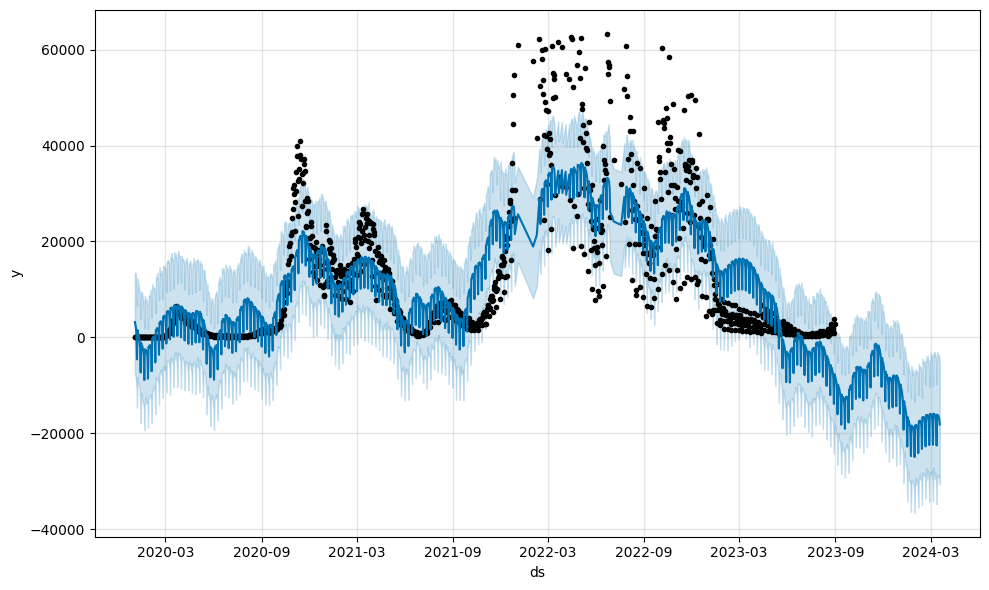

In [120]:
#dealing with outliers 
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=200)
forecast = m.predict(future)
fig = m.plot(forecast)

The effect of the extreme outliers in 2021 reverberated into the future.I will set the outliers as NA since Prophet can handle missing values.

In [145]:
#set outliers to NA
Q1 = train['y'].quantile(0.25)
Q3 = train['y'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = train[(train['y'] < lower_bound) | (train['y'] > upper_bound)]

train.loc[train['y'] < lower_bound, 'y'] = None
train.loc[train['y'] > upper_bound, 'y'] = None

## Model Development
### Model 1

In [146]:
# holidays
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(train)
m.train_holiday_names

00:45:58 - cmdstanpy - INFO - Chain [1] start processing
00:45:58 - cmdstanpy - INFO - Chain [1] done processing


0                          Martin Luther King Jr. Day
1                               Washington's Birthday
2                                        Columbus Day
3                                      New Year's Day
4                                        Memorial Day
5                                    Independence Day
6                         Independence Day (Observed)
7                                           Labor Day
8                                        Veterans Day
9                                        Thanksgiving
10                                      Christmas Day
11                          New Year's Day (Observed)
12               Juneteenth National Independence Day
13    Juneteenth National Independence Day (Observed)
14                           Christmas Day (Observed)
15                            Veterans Day (Observed)
dtype: object

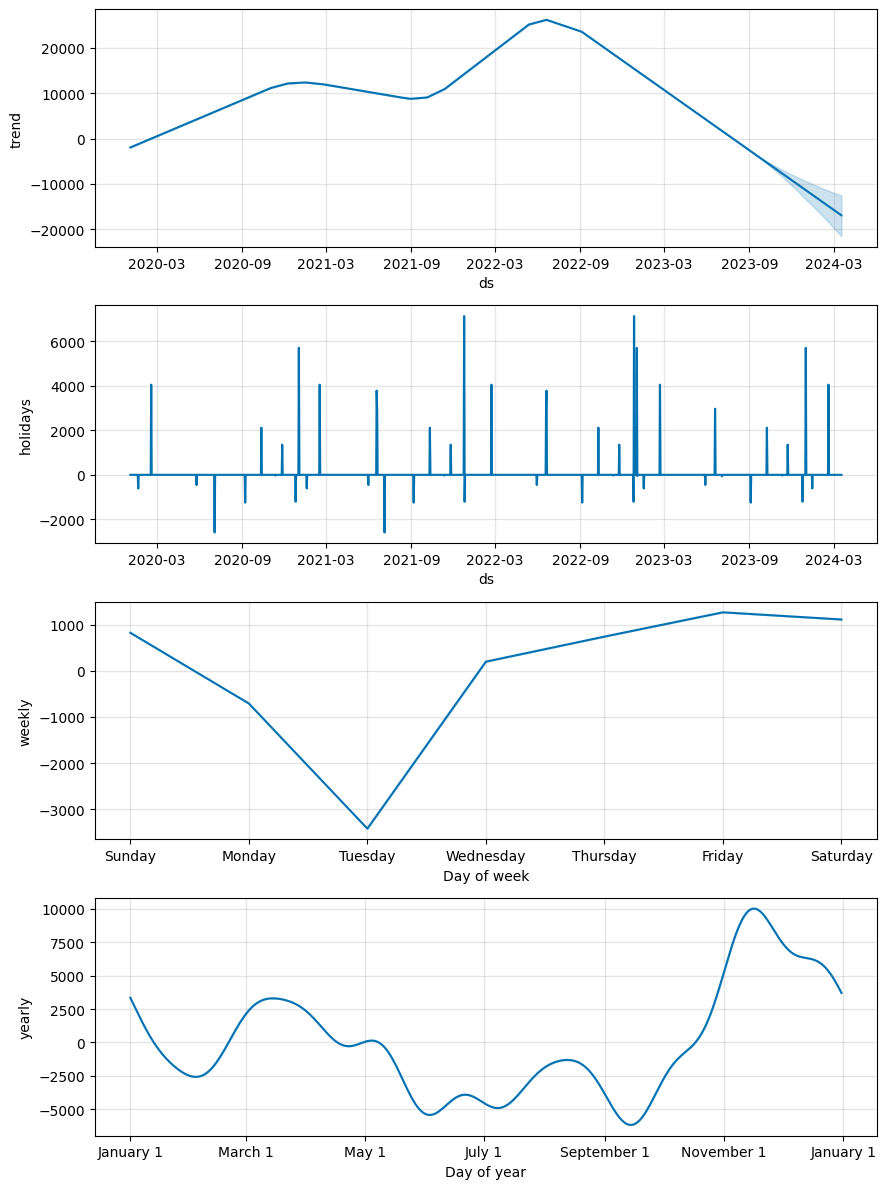

In [147]:
# visualize holidays and seasonality
forecast = m.predict(future)
fig = m.plot_components(forecast)

In [148]:
# base model with holiday
train_pred=m.predict(train).set_index('ds')
train_pred.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-1970.70543,-5558.417362,10554.586270,-1970.70543,-1970.70543,0.0,0.0,0.0,0.0,0.0,...,1263.927060,1263.927060,1263.927060,2969.528925,2969.528925,2969.528925,0.0,0.0,0.0,2262.750555
2020-01-04,-1927.36780,-5998.760262,10041.114848,-1927.36780,-1927.36780,0.0,0.0,0.0,0.0,0.0,...,1108.862169,1108.862169,1108.862169,2666.002797,2666.002797,2666.002797,0.0,0.0,0.0,1847.497166
2020-01-05,-1884.03017,-6742.051338,9219.983936,-1884.03017,-1884.03017,0.0,0.0,0.0,0.0,0.0,...,821.252202,821.252202,821.252202,2362.781252,2362.781252,2362.781252,0.0,0.0,0.0,1300.003284
2020-01-06,-1840.69254,-8437.741040,7504.008536,-1840.69254,-1840.69254,0.0,0.0,0.0,0.0,0.0,...,-709.221713,-709.221713,-709.221713,2062.125857,2062.125857,2062.125857,0.0,0.0,0.0,-487.788396
2020-01-07,-1797.35491,-11365.653165,3967.851920,-1797.35491,-1797.35491,0.0,0.0,0.0,0.0,0.0,...,-3418.833337,-3418.833337,-3418.833337,1766.106332,1766.106332,1766.106332,0.0,0.0,0.0,-3450.081914


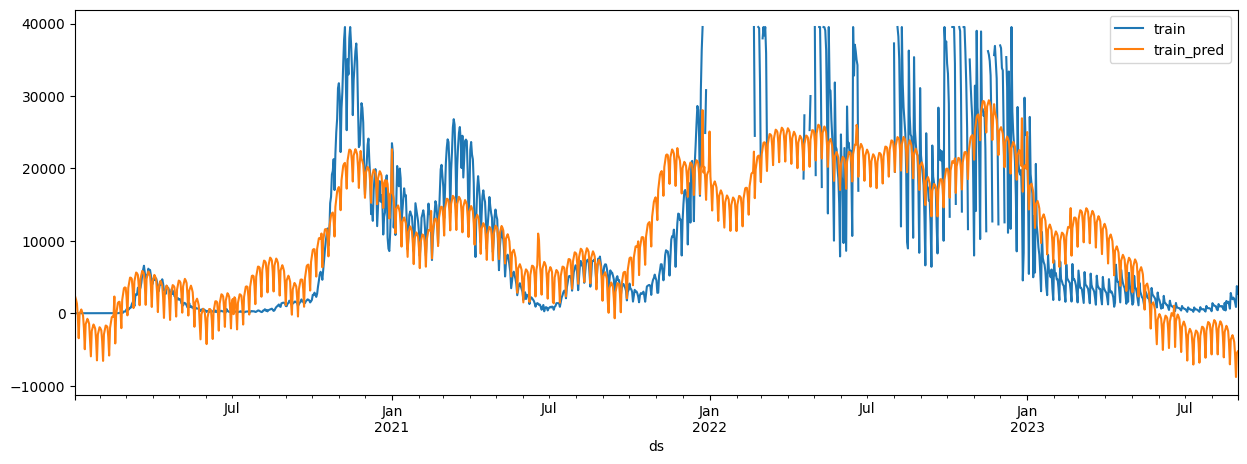

In [149]:
pd.concat([train.set_index('ds'),train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

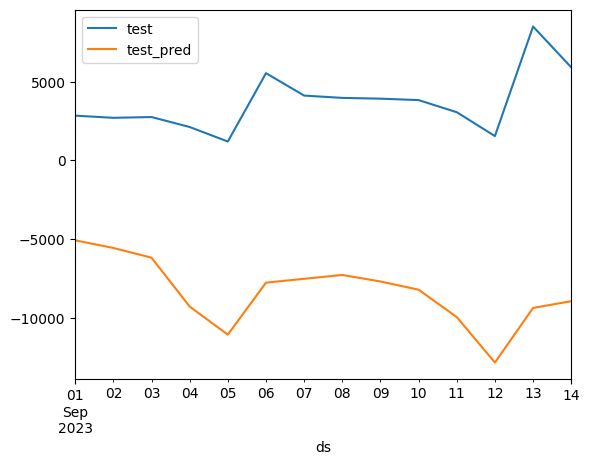

In [150]:
test_pred=m.predict(test).set_index('ds')
pd.concat([test.set_index('ds'),test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [151]:
test_rmse = np.sqrt(mean_squared_error(test['y'], test_pred['yhat']))
print(f'Test RMSE: {test_rmse}')

Test RMSE: 12329.612661549154


### Model 2

In [152]:
# take into account holiday and incubation period
from prophet.make_holidays import make_holidays_df

us_holidays = make_holidays_df(
    year_list=[2020 + i for i in range(4)], country='US'
)
us_holidays.head(n=10)

,ds,holiday
0,2020-01-20,Martin Luther King Jr. Day
1,2020-02-17,Washington's Birthday
2,2020-10-12,Columbus Day
3,2020-01-01,New Year's Day
4,2020-05-25,Memorial Day
5,2020-07-04,Independence Day
6,2020-07-03,Independence Day (Observed)
7,2020-09-07,Labor Day
8,2020-11-11,Veterans Day
9,2020-11-26,Thanksgiving


In [153]:
# italy had two lockdowns
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-09', 'lower_window': 0, 'ds_upper': '2020-05-18'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-09', 'lower_window': 0, 'ds_upper': '2021-02-07'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
holidays = pd.concat((lockdowns, us_holidays))
holidays = holidays.reset_index()
holidays.loc[2:, 'ds_upper'] = holidays.loc[2:, 'ds'] + pd.Timedelta(days=7)
holidays.head()

,index,holiday,ds,lower_window,ds_upper,upper_window
0,0,lockdown_1,2020-03-09,0.0,2020-05-18,70.0
1,1,lockdown_2,2020-11-09,0.0,2021-02-07,90.0
2,0,Martin Luther King Jr. Day,2020-01-20,NaN,2020-01-27,NaN
3,1,Washington's Birthday,2020-02-17,NaN,2020-02-24,NaN
4,2,Columbus Day,2020-10-12,NaN,2020-10-19,NaN


In [154]:
m2 = Prophet(holidays=holidays,
             n_changepoints = 100,
             changepoint_prior_scale = 0.1,
             seasonality_mode = 'multiplicative'
             )
m2.fit(train)

00:46:29 - cmdstanpy - INFO - Chain [1] start processing
00:46:30 - cmdstanpy - INFO - Chain [1] done processing


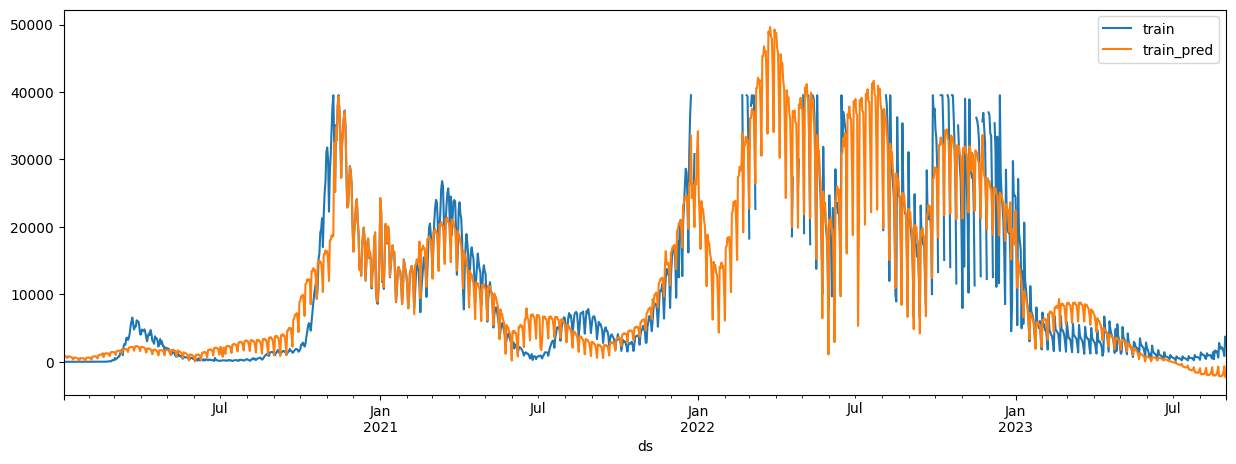

In [155]:
train_pred=m2.predict(train).set_index('ds')
pd.concat([train.set_index('ds'),train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

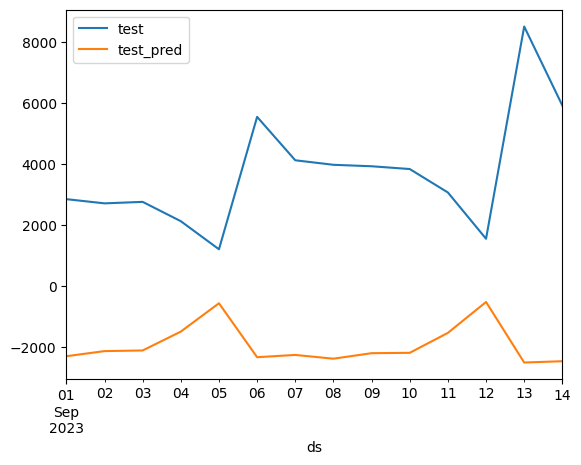

In [156]:
test_pred=m2.predict(test).set_index('ds')
pd.concat([test.set_index('ds'),test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [137]:
test_rmse = np.sqrt(mean_squared_error(test['y'], test_pred['yhat']))
print(f'Test RMSE: {test_rmse}')

Test RMSE: 5857.317685907362


In [138]:
test_rmse = np.sqrt(mean_squared_error(test['y'], test_pred['yhat']))
print(f'Test RMSE: {test_rmse}')

Test RMSE: 5857.317685907362


## Cross Validation
https://zerotomastery.io/blog/time-series-forecasting-with-facebook-prophet/#:~:text=Cross%2Dvalidation%20is%20an%20important,on%20the%20corresponding%20testing%20set.


In [37]:
pip install fbprophet

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 4.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.0 MB/s eta 0:00:00ta 0:00:01
INFO: pip is looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 9.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 3.0 MB/s eta 0:00:0000:01

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics

#Store the results
rmse = []
#Loop
for params in grid:
  #model
  m = Prophet(seasonality_mode = params['seasonality_mode'],
              seasonality_prior_scale = params['seasonality_prior_scale'],
              holidays_prior_scale = params['holidays_prior_scale'],
              changepoint_prior_scale = params['changepoint_prior_scale'])
  m.add_regressor('regressor_1')
  m.add_regressor('regressor_2')
  m.fit(df)

  #CV
  df_cv = cross_validation(m,
                          horizon = '31 days',
                          period = '16 days',
                          initial = '365 days',
                          parallel = 'processes')

  #Measure the error and store the result
  error = performance_metrics(df_cv)["rmse"].mean()
  rmse.append(error)

#Check the results
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
best_params = tuning_results[tuning_results.rmse == tuning_results.rmse.min()].transpose()
Best_params